# Amazon Recommender System
![amazon](../images/amazon.png)

This EDA will show basic cleaning for the two data and some summary.

## Part 1: Review Data

In [3]:
# import library
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.ticker import FuncFormatter

import visualizations as viz

- The timestamp column is removed.
- The data type for the rating column is updated to integers.
- There are three columns: customer id, video game item id, rating values.

In [4]:
df = pd.read_csv('http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games.csv', 
                 names=['item', 'user', 'rating', 'timestamp'])

# changing column orders
# drop unnecessary column
df = df[['user', 'item', 'rating']]

# update datatype for rating values
df.rating = df.rating.astype('int32')

In [5]:
# checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565349 entries, 0 to 2565348
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   user    object
 1   item    object
 2   rating  int32 
dtypes: int32(1), object(2)
memory usage: 48.9+ MB


In [6]:
# print the first 5 rows
df.head()

,user,item,rating
0,A21ROB4YDOZA5P,0439381673,1
1,A3TNZ2Q5E7HTHD,0439381673,3
2,A1OKRM3QFEATQO,0439381673,4
3,A2XO1JFCNEYV3T,0439381673,1
4,A19WLPIRHD15TH,0439381673,4


- Every rating value is integers from 1 to 5.

In [7]:
df.rating.value_counts()

5    1487366
4     412413
1     311891
3     212346
2     141333
Name: rating, dtype: int64

- There is no missing values.

In [8]:
df.isna().sum()

user      0
item      0
rating    0
dtype: int64

- More than half of the ratings are 5.

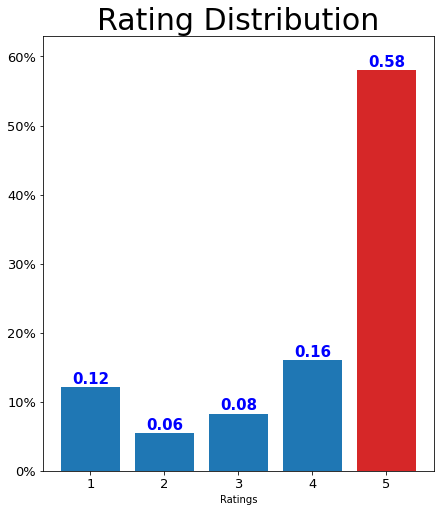

In [9]:
review_dist = pd.DataFrame(df.rating.value_counts(normalize = True)).reset_index().sort_values(by = 'index')
review_dist.rename(columns = {'index': 'review_rating', 'rating':'percentage'}, inplace = True)

# show rating distribution
viz.result_1(review_dist)

## Part 2: Metadata

This data contains information on video games. The selected information is the brand name, category, game item id, and game title.

In [10]:
import gzip
import json

# reading json file line by line
df_meta = pd.read_json('http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Video_Games.json.gz', 
                    lines=True)

# select relevant columns only
df_meta_basic = df_meta[['title', 'asin', 'category', 'brand']]

# formatting brand names
df_meta_basic['brand'] = df_meta_basic['brand'].str.replace("\n", "")
df_meta_basic['brand'] = df_meta_basic['brand'].str.replace("by", "")
df_meta_basic['brand'] = df_meta_basic['brand'].str.replace(" ", "")
df_meta_basic['brand'] = df_meta_basic['brand'].str.lower()

- Duplicate rows are checked and then removed.

In [12]:
# checking duplicates
df_meta_basic.duplicated(subset=['asin']).value_counts()

False    71911
True     12908
dtype: int64

In [13]:
# drop duplicates
df_meta_basic.drop_duplicates(subset=['asin'], inplace = True)

In [15]:
df_meta_basic

,title,asin,category,brand
0,Reversi Sensory Challenger,0042000742,"[Video Games, PC, Games]",fidelityelectronics
1,Medal of Honor: Warfighter - Includes Battlefi...,0078764343,"[Video Games, Xbox 360, Games, </span></span><...",eagames
2,street fighter 2 II turbo super nintendo snes ...,0276425316,"[Video Games, Retro Gaming & Microconsoles, Su...",nintendo
3,Xbox 360 MAS STICK,0324411812,"[Video Games, Xbox 360, Accessories, Controlle...",massystems
4,Phonics Alive! 3: The Speller,0439335310,"[Video Games, PC, Games, </span></span></span>...",advancedsoftwarepty.ltd.
...,...,...,...,...
84814,Lego Star Wars: The Force Awakens - PS Vita [D...,B01HJ1521Y,"[Video Games, PlayStation Vita, Digital Games ...",warnerbros.
84815,Lego Star Wars: The Force Awakens Season Pass...,B01HJ14TTA,"[Video Games, PlayStation 4, Digital Games & D...",warnerbros.
84816,The Technomancer - PS4 [Digital Code],B01HJ14OT0,"[Video Games, PlayStation 4, Digital Games & D...",focushomeinteractive
84817,"Repair T8 T6 Tools for XBOX One Xbox 360, YTTL...",B01HJC33WS,"[Video Games, Xbox 360, Accessories, </span></...",yttl


## Part 3: Combine Multiple Information
Information from review data will be added to the metadata, and then many columns of categories will be also added to the metadata.

#### Adding Mean of Ratings
Mean of ratings from review data will be calculated and then assigined to each video game in the metadata.

In [14]:
# Calculate mean ratings for each item
rating_avg_df = df.groupby('item').mean().reset_index()

# rename column names for easier merging with meta data
rating_avg_df.rename(columns = {'rating' : 'avg_rating', 
                                'item' : 'asin'}, 
                     inplace = True)

# assign mean ratings to each item using merging
df_meta_final = pd.merge(df_meta_basic, rating_avg_df, on='asin', how='inner')

df_meta_final

,title,asin,category,brand,avg_rating
0,Reversi Sensory Challenger,0042000742,"[Video Games, PC, Games]",fidelityelectronics,5.000000
1,Medal of Honor: Warfighter - Includes Battlefi...,0078764343,"[Video Games, Xbox 360, Games, </span></span><...",eagames,4.750000
2,street fighter 2 II turbo super nintendo snes ...,0276425316,"[Video Games, Retro Gaming & Microconsoles, Su...",nintendo,5.000000
3,Xbox 360 MAS STICK,0324411812,"[Video Games, Xbox 360, Accessories, Controlle...",massystems,1.000000
4,Phonics Alive! 3: The Speller,0439335310,"[Video Games, PC, Games, </span></span></span>...",advancedsoftwarepty.ltd.,3.000000
...,...,...,...,...,...
71904,Lego Star Wars: The Force Awakens - PS Vita [D...,B01HJ1521Y,"[Video Games, PlayStation Vita, Digital Games ...",warnerbros.,5.000000
71905,Lego Star Wars: The Force Awakens Season Pass...,B01HJ14TTA,"[Video Games, PlayStation 4, Digital Games & D...",warnerbros.,3.000000
71906,The Technomancer - PS4 [Digital Code],B01HJ14OT0,"[Video Games, PlayStation 4, Digital Games & D...",focushomeinteractive,5.000000
71907,"Repair T8 T6 Tools for XBOX One Xbox 360, YTTL...",B01HJC33WS,"[Video Games, Xbox 360, Accessories, </span></...",yttl,4.590909


### Adding Columns for Console Names and Brand Names
This step will try to gain console information and brand names. Each console name or brand name will be added as a column name. This will tell us if a game item belongs to a console name or a brand name.

In [16]:
# a function to get console information from category column
# this will try to search console name by looping category values
def find_cat(df, cat):
    length = []
    for i in df.index:
        text_list = df.iloc[i].category
        length.append(len([t for t in text_list if cat in t.replace(" ", "").lower()]))
    return pd.DataFrame(length, columns = [cat])

In [17]:
# Console names to be searched
console = ['pc', 'xbox', 'xbox360', 'xboxone', 
 'playstation', 'playstation2', 'playstation3', 'playstation4', 
 'cube', 'wii', 'switch', 'nintendo',
 'accessories', 
]

# Select 30 brand names with the highest counts
# control the number of columns
brand = df_meta_final.brand.value_counts().head(30).index

# search each console name and add each to the metadata as a new column
for c in console:
    example = find_cat(df_meta_final, c)
    # If a name is found multiplel times, set it to 1
    example[c] = example[c].map(lambda x: 1 if x >= 1 else 0)
    df_meta_final = pd.concat([df_meta_final, example], axis = 1)

# search each brand name and add each to the metadata as a new column
for b in brand:
    df_meta_final[b] = df_meta_final.brand.map(lambda x: 1 if x == b else 0)
    
# drop original columns
df_meta_final.drop(['category', 'brand'], axis = 1, inplace = True)

- The example rows would not show all columns. Instead, the column names are displayed below.

In [18]:
df_meta_final.columns

Index(['title', 'asin', 'avg_rating', 'pc', 'xbox', 'xbox360', 'xboxone',
       'playstation', 'playstation2', 'playstation3', 'playstation4', 'cube',
       'wii', 'switch', 'nintendo', 'accessories', '', 'electronicarts',
       'activision', 'sony', 'ubisoft', 'sega', 'microsoft', 'atari', 'thq',
       'konami', 'capcom', 'squareenix', 'madcatz', 'bandai', '2k', 'encore',
       'generic', 'dreamgear', 'intec', 'vivamedia', 'vivendiuniversal',
       'wbgames', 'skinit', 'unknown', 'wraptorskinz', 'modfreakz', 'midway',
       'hori'],
      dtype='object')